In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LogNorm
import matplotlib.dates as mdates
%matplotlib inline
def phi_m_dyer(zeta):
    gamma = 16.0
    karman = 0.4
    beta = 5.0
    epsilon = 1.e-6

    if (zeta < -epsilon):
        phim = 1. / ((1. - gamma * zeta) ** 0.25)
    #
    # Stably stratified case
    elif (zeta > epsilon):
        phim = (1. + beta * zeta)
    #
    # Neutrally stratified case
    elif (zeta >= -epsilon) & (zeta <= epsilon):
        phim = 1.
    return phim

def phi_h_dyer(zeta):
    gamma = 16.0
    karman = 0.4
    beta = 5.0
    epsilon = 1.e-6

    if (zeta < -epsilon):
        phih = 1. / ((1. - gamma * zeta) ** 0.5)
    #
    # Stably stratified case
    elif (zeta > epsilon):
        phih= (1. + beta * zeta)
    #
    # Neutrally stratified case
    elif (zeta >= -epsilon) & (zeta <= epsilon):
        phih = 1.
    return phih

def phi_m_businger(zeta):
    gamma = 15.0
    karman = 0.35
    beta = 4.7
    epsilon = 1.e-6

    if (zeta < -epsilon):
        phim = 1. / ((1. - gamma * zeta) ** 0.25)
    #
    # Stably stratified case
    elif (zeta > epsilon):
        phim = (1. + beta * zeta)
    #
    # Neutrally stratified case
    elif (zeta >= -epsilon) & (zeta <= epsilon):
        phim = 1.
    return phim

def phi_h_businger(zeta):
    gamma = 9.0
    karman = 0.35
    beta = 4.7
    epsilon = 1.e-6

    if (zeta < -epsilon):
        phih = 0.74 * (1 - gamma * zeta) ** -0.5
    #
    # Stably stratified case
    elif (zeta > epsilon):
        phih= (0.74 + beta * zeta)
    #
    # Neutrally stratified case
    elif (zeta >= -epsilon) & (zeta <= epsilon):
        phih = 0.74
    return phih

In [2]:
cabauw_data = pd.read_csv("/glade/p/cisl/aiml/fasteddy/cabauw_derived_data_20201203.csv", index_col="Time")

In [72]:
cabauw_data

,global_horizontal_irradiance:0_m:W_m-2,zenith:0_m:degrees,azimuth:0_m:degrees,temperature:2_m:K,temperature:10_m:K,temperature:20_m:K,temperature:40_m:K,pressure:2_m:hPa,potential_temperature:2_m:K,potential_temperature:10_m:K,...,bulk_richardson:10_m:None,bulk_richardson:2_m:None,bulk_richardson:10-2_m:None,obukhov_length:surface:m,sensible_heat_flux:surface:W_m-2,latent_heat_flux:surface:W_m-2,friction_velocity:surface:m_s-1,temperature_scale:surface:K,soil_heat_flux:surface:W_m-2,moisture_scale:surface:g_kg-1
Time,,,,,,,,,,,,,,,,,,,,,
2003-02-26 16:30:00,35.979324,83.015427,246.148596,281.783333,282.649993,282.816660,282.983320,1013.033333,280.742733,281.606193,...,0.354575,0.058844,0.061282,8.328529,-8.496646,-6.808841,0.084675,0.086550,-6.035598,-0.027307
2003-02-26 16:40:00,23.142271,84.432283,248.186295,281.516667,282.449993,282.683333,282.916653,1013.100000,280.471779,281.401642,...,0.342714,0.056760,0.059865,10.164985,-10.046557,-8.931672,0.100381,0.080764,-7.224256,-0.031984
2003-02-26 16:50:00,14.605255,85.869416,250.204700,281.283327,282.249993,282.516667,282.783327,1013.166667,280.234036,281.197096,...,0.252357,0.040450,0.050786,10.220637,-13.197426,-3.720794,0.112807,0.093993,-8.136243,-0.017638
2003-02-26 17:00:00,8.416262,87.324864,252.206226,281.116660,282.083327,282.316667,282.550000,1013.233333,280.062724,281.025767,...,0.217559,0.034236,0.046958,11.398365,-12.462662,-0.062060,0.114993,0.086212,-8.757786,-0.004048
2003-02-26 17:10:00,3.797258,88.796708,254.193341,280.883327,281.883327,282.083333,282.350000,1013.300000,279.825008,280.821241,...,0.210390,0.032179,0.050065,13.575507,-9.312073,-1.692232,0.106633,0.063172,-9.087326,-0.015481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-04-12 06:30:00,135.162697,77.119872,92.219508,282.349987,282.383327,282.283327,282.116667,1017.300000,280.969705,281.002880,...,-0.000197,-0.000117,0.000388,-512.510113,-0.738024,48.367692,0.353542,0.002188,8.971845,0.048178
2017-04-12 06:40:00,145.492310,75.580565,94.209604,282.649993,282.594433,282.494433,282.316660,1017.133333,281.281404,281.226111,...,-0.001800,-0.000263,-0.000485,-221.821412,1.454824,52.337982,0.388500,-0.003313,10.045609,0.048243
2017-04-12 06:50:00,135.985190,74.045210,96.216733,282.783333,282.683330,282.583323,282.416653,1017.000000,281.424635,281.325111,...,-0.000735,0.000001,-0.000742,316.903880,-2.261808,50.233645,0.405652,0.004520,8.907083,0.043900


In [3]:
cabauw_data["zeta_m"] = 15.0 / cabauw_data["obukhov_length:surface:m"]
cabauw_data["zeta_h"] = 6.0 / cabauw_data["obukhov_length:surface:m"]

In [4]:
wspd_20_m = np.maximum(0.1, cabauw_data["wind_speed:20_m:m_s-1"])
wspd_10_m = np.maximum(0.1, cabauw_data["wind_speed:10_m:m_s-1"])
cabauw_data["phi_m"] =  (wspd_20_m - wspd_10_m) / 10 * 0.4 * 15 / np.maximum(0.1, cabauw_data["friction_velocity:surface:m_s-1"])

In [5]:
temp_10_m = cabauw_data["potential_temperature:10_m:K"]
temp_2_m = cabauw_data["potential_temperature:2_m:K"]
t_diff = np.where(np.abs(temp_10_m - temp_2_m) > 0.1, temp_10_m - temp_2_m, 0.1)
t_scale = np.where(np.abs(cabauw_data["temperature_scale:surface:K"]) > 0.1, cabauw_data["temperature_scale:surface:K"], 0.1)
cabauw_data["phi_h"] =  t_diff / 8 * 0.4 * 6 / t_scale

In [6]:
zeta = np.arange(-2, 2.1, 0.01)
phi_m_out = np.zeros((2, zeta.size))
phi_h_out = np.zeros((2, zeta.size))

for i in range(zeta.size):
    phi_m_out[0, i] = phi_m_dyer(zeta[i])
    phi_m_out[1, i] = phi_m_businger(zeta[i])
    phi_h_out[0, i] = phi_h_dyer(zeta[i])
    phi_h_out[1, i] = phi_h_businger(zeta[i])

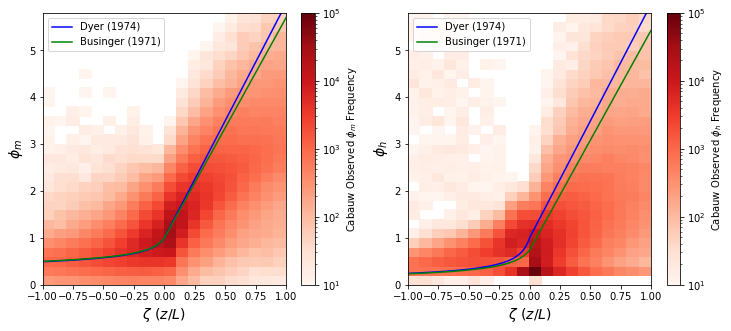

In [7]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(zeta, phi_m_out[0], color="blue", label="Dyer (1974)")
plt.plot(zeta, phi_m_out[1], color="green", label="Businger (1971)")

plt.hist2d(cabauw_data["zeta_m"], cabauw_data["phi_m"], 
           bins=(np.arange(-1, 1.1, 0.1), np.arange(0, 6, 0.2)), cmin=10, norm=LogNorm(vmax=1e5), cmap="Reds")
plt.xlabel("$\zeta\ (z/L)$", fontsize=14)
plt.colorbar(label="Cabauw Observed $\phi_m$ Frequency")
plt.ylabel("$\phi_m$", fontsize=14)

plt.legend(loc=0)
plt.subplot(1, 2, 2)

plt.plot(zeta, phi_h_out[0], color="blue", label="Dyer (1974)")
plt.plot(zeta, phi_h_out[1], color="green", label="Businger (1971)")

plt.hist2d(cabauw_data["zeta_h"], cabauw_data["phi_h"], 
           bins=(np.arange(-1, 1.1, 0.1), np.arange(0, 6, 0.2)), cmin=10, norm=LogNorm(vmax=1e5), cmap="Reds")
plt.colorbar(label="Cabauw Observed $\phi_h$ Frequency")
plt.xlabel("$\zeta\ (z/L)$", fontsize=14)
plt.ylabel("$\phi_h$", fontsize=14)

plt.legend(loc=0)
plt.savefig("cabauw_phi_comparison.png", dpi=250, bbox_inches="tight")

In [21]:
phi_m_out

array([0.41722614, 0.42244248, 0.42800213, 0.43394803, 0.44033133,
       0.4472136 , 0.45466972, 0.46279204, 0.47169596, 0.48152824,
       0.49247906, 0.50480055, 0.51883615, 0.53506931, 0.55420895,
       0.57735027, 0.60630628, 0.64438141, 0.69853421, 0.78751106,
       1.        ,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan])

In [9]:
ls /glade/scratch/cbecker/MLSurface_data/

processed_Cabauw_30min_01012013-12312015.csv
processed_Cabauw_30min_02262003-04122017.csv
processed_Cabauw_30min_02262003-12312015.csv
processed_Cabauw_30min_03012013-12312015.csv
processed_Idaho_30min_03012015-12312017.csv
surface_layer_model_predictions_cabauw.csv
surface_layer_model_predictions_idaho.csv


In [8]:
ml_preds_cabauw = pd.read_csv("/glade/scratch/cbecker/MLSurface_data/cabauw_train_cabauw_test_predictions.csv", index_col="Time")
ml_train_test_cabauw = pd.read_csv("/glade/scratch/cbecker/MLSurface_data/processed_Cabauw_30min_02262003-04122017.csv", index_col="Time")
combined_preds = pd.merge(ml_preds_cabauw, ml_train_test_cabauw, how="inner", left_index=True, right_index=True, suffixes=("_pred", "_train"))

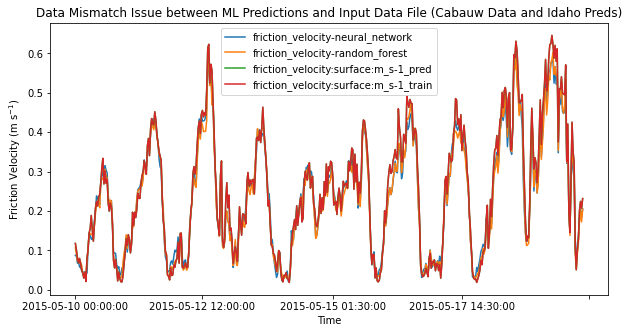

In [9]:
start_date = "2015-05-10"
end_date = "2015-05-20"
fig, ax = plt.subplots(figsize=(10, 5))
locator = mdates.AutoDateLocator(minticks=3, maxticks=6)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
combined_preds["friction_velocity-neural_network"].loc[start_date:end_date].plot()
combined_preds["friction_velocity-random_forest"].loc[start_date:end_date].plot()
combined_preds["friction_velocity:surface:m_s-1_pred"].loc[start_date:end_date].plot()
combined_preds["friction_velocity:surface:m_s-1_train"].loc[start_date:end_date].plot()
plt.legend()
plt.ylabel("Friction Velocity (m s$^{-1}$)")
plt.title("Data Mismatch Issue between ML Predictions and Input Data File (Cabauw Data and Idaho Preds)")
plt.savefig("fv_ts_issue_w_idaho_preds.png", dpi=250, bbox_inches="tight")

In [15]:
combined_preds["zeta_m"] = 15.0 / combined_preds["obukhov_length:surface:m"]
combined_preds["zeta_h"] = 6.0 / combined_preds["obukhov_length:surface:m"]
wspd_20_m = np.maximum(0.1, combined_preds["wind_speed:20_m:m_s-1"])
wspd_10_m = np.maximum(0.1, combined_preds["wind_speed:10_m:m_s-1"])
combined_preds["phi_m_random-forest"] =  (wspd_20_m - wspd_10_m) / 10 * 0.4 * 15 / np.maximum(0.1, combined_preds["friction_velocity-random_forest"])

In [16]:
temp_10_m = combined_preds["potential_temperature:10_m:K"]
temp_2_m = combined_preds["potential_temperature:2_m:K"]
t_diff = np.where(np.abs(temp_10_m - temp_2_m) > 0.1, temp_10_m - temp_2_m, 0.1)
t_scale = np.where(np.abs(combined_preds["temperature_scale-random_forest"]) > 0.1, combined_preds["temperature_scale-random_forest"], 0.1)
combined_preds["phi_h_random-forest"] =  t_diff / 8 * 0.4 * 6 / t_scale

In [104]:
ml_preds_cabauw.columns

Index(['friction_velocity-random_forest', 'friction_velocity-neural_network',
       'friction_velocity-mo', 'temperature_scale-random_forest',
       'temperature_scale-neural_network', 'temperature_scale-mo',
       'moisture_scale-random_forest', 'moisture_scale-neural_network',
       'moisture_scale-mo', 'sensible_heat_flux:surface:W_m-2',
       'latent_heat_flux:surface:W_m-2', 'bulk_richardson:10_m:None',
       'air_density:10_m:kg_m-3', 'friction_velocity:surface:m_s-1',
       'moisture_scale:surface:g_kg-1', 'temperature_scale:surface:K'],
      dtype='object')

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(zeta, phi_m_out[0], color="blue", label="Dyer (1974)")
plt.plot(zeta, phi_m_out[1], color="green", label="Businger (1971)")

plt.hist2d(combined_preds["zeta_m"], combined_preds["phi_m_random-forest"], 
            bins=(np.arange(-1, 1.1, 0.1), np.arange(0, 6, 0.2)), cmin=1, norm=LogNorm(vmax=1e3), cmap="Reds")
plt.xlabel("$\zeta\ (z/L)$", fontsize=14)
plt.colorbar(label="Cabauw Random Forest $\phi_m$ Frequency")
plt.ylabel("$\phi_m$", fontsize=14)

plt.legend(loc=0)
plt.subplot(1, 2, 2)

plt.plot(zeta, phi_h_out[0], color="blue", label="Dyer (1974)")
plt.plot(zeta, phi_h_out[1], color="green", label="Businger (1971)")

plt.hist2d(combined_preds["zeta_h"], combined_preds["phi_h_random-forest"], 
           bins=(np.arange(-1, 1.1, 0.1), np.arange(0, 6, 0.2)), cmin=1, norm=LogNorm(vmax=1e3), cmap="Reds")
plt.colorbar(label="Cabauw Random Forest $\phi_h$ Frequency")
plt.xlabel("$\zeta\ (z/L)$", fontsize=14)
plt.ylabel("$\phi_h$", fontsize=14)

plt.legend(loc=0)
plt.savefig("cabauw_rf_phi_comparison.png", dpi=250, bbox_inches="tight")